# 6.S083 / 18.S190 Spring 2020: Problem set 4

Submission deadline: Tuesday April 28, 2020 at 11:59pm.


In this problem set, we will look at the simplest epidemic model in which
we take **space** into account.

The simplest way to do this is to use **discrete space**: each agent lives
in a cell of a square grid. For simplicity in the coding we will not allow more
than one agent in any one grid cell, but this means that we need to carefully
design the rules of the model to respect this.

The effect of space is thus to *restrict* the set of other agents with which
a given agent can interact at any one time. (Compare the previous Problem Set,
in which any agent could interact with any other.)


## Exercise 1: Moving in 2D

In this exercise we will implement a random walk on a 2D lattice (grid).

1. Define an abstract type `AbstractWalker`.

In [1]:
abstract type AbstractWalker end

2. Define an abstract type `Abstract2DWalker` that is a subtype of `AbstractWalker` (using  `<:`).

In [2]:
abstract type Abstract2DWalker <: AbstractWalker end

3. Define an immutable type `Location` that contains integers `x` and `y`.

In [3]:
struct Location
    x::Int64
    y::Int64
end

In [4]:
Location((a,b)) = Location(a,b)
Location(x::Tuple{Int64,Int64}) = Location(x[1],x[2])

Location

4. Define a `Walker2D` type that is a subtype of `AbstractWalker2D`. It should contain a field `position` that is a `Location` object.

In [5]:
mutable struct Walker2D <: Abstract2DWalker
    position::Location
end

5. Check that Julia automatically provides a constructor function `Walker2D(position)` that accepts an object of type `Location`.

    Construct a `Walker` located at the origin.

In [6]:
w = Walker2D(Location(0,0))

Walker2D(Location(0, 0))

6. Write a new method of the constructor for `Walker2D` that accepts two integers, $x$ and $y$, i.e. `Walker2D(x, y)`.

In [7]:
Walker2D(x::Int64,y::Int64) = Walker2D(Location(x,y))

Walker2D

7. Write a function `make_tuple` that takes an object of type `Location` and returns the corresponding tuple
`(x, y)`.

In [8]:
make_tuple(l::Location) = (l.x,l.y)

make_tuple (generic function with 1 method)

In the following questions, the functions should take an object of type `AbstractWalker2D`
(or you can just leave them untyped).

8. Write a getter function `pos` that returns the position as a `Location` object.

In [9]:
pos(w::Abstract2DWalker) = w.position

pos (generic function with 1 method)

9. Write a setter function `set_pos!` that sets the position to a given location `l`.

In [10]:
function set_pos!(w::Abstract2DWalker, l::Location)
    w.position = l
end
function set_pos!(w::Abstract2DWalker, l::Tuple{Int64,Int64})
    w.position = Location(l)
end

set_pos! (generic function with 2 methods)

10. Write a function `jump` that returns a possible new position for a walker after a 2D jump
as a `Location` object. This function should *not* modify its argument,
and hence does not have a `!` in its name.

    Jumps are equally likely in the directions right, up, left and down.

    A nice way to implement this is to make a tuple `neighbours` of possible
    destinations.

In [11]:
function jump(w::Abstract2DWalker)
    loc = make_tuple(pos(w))
    move = rand(   ((0,1),(0,-1),(1,0),(-1,0))  )
    new_loc = loc .+ move
    return Location(new_loc)
end

jump (generic function with 1 method)

11. Write a function `jump!` that moves a walker to a new position. What arguments does the function need? Use your `jump` function to write `jump!`.

In [12]:
function jump!(w::Abstract2DWalker)
    new_loc = jump(w)
    set_pos!(w, new_loc)
end

jump! (generic function with 1 method)

12. Write a function `trajectory` that calculates a trajectory of a 2D walker of length $N$.

In [13]:
function trajectory(w::Abstract2DWalker, N::Int64)
    traj = Tuple{Int64,Int64}[]
    for i in 1:N
        jump!(w)
        push!(traj,make_tuple(pos(w)))
    end
    return traj
end

trajectory (generic function with 1 method)

13. Plot 10 trajectories of length 10,000 on a single figure, all starting at the origin.

    Note that `Plots.jl` can accept a `Vector` of `Tuple`s, i.e. $(x, y)$ pairs, as the coordinates to plot.

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1260


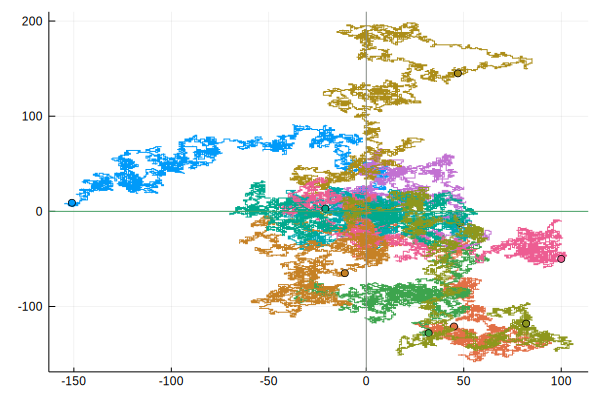

In [14]:
using Plots
plot(leg = false)
N = 10000
num_traj = 10
for i in 1:num_traj
    data = trajectory(Walker2D(0,0), N)
    plot!(data, color = i)
    scatter!(data[end], color = i)
end
vline!([0], label = "")
hline!([0],  label = "")

## Exercise 2: Making agents move

In this exercise we will combine our `Agent` type from Problem Set 3 with the 2D random walker that we just created, by adding a position to the `Agent` type.

1. Define a mutable type `Agent` that is a subtype of `AbstractWalker2D` from Exercise 1, since it will behave like a random walker and lives in 2D.

    `Agent` should contain a `position` of type `Location`, as well as a `state` of type `InfectionStatus`.

    (For simplicity we will not require a `num_infected` field, but feel free to do so if you would like.)


In [15]:
@enum InfectionStatus S I R
mutable struct Agent <: Abstract2DWalker
    position::Location
    state::InfectionStatus
    num_infected::Int64
end
Agent(start::Tuple{Int64,Int64}) = Agent(Location(start), S, 0)
Agent(x::Int64,y::Int64) = Agent(Location(x,y), S, 0)

Agent

2. Agents live in a box of side length `L`, centered at the origin. We need to decide (i.e. model) what happens when they reach the walls of the box (boundaries), i.e. what kind of **boundary conditions** to use.

    One type of boundary condition that is relatively simple to implement are **reflecting boundary conditions**, as follows:

    Each side of the box is a reflective mirror. We can model this using "bounce-back": if the particle tries to jump beyond one of the boundaries, it hits a springy wall and bounces back to the *same* position that it started from. That is, it **proposes** to take a step, but "realises" that it is blocked in that direction, so just stays where it is instead for that step.


    Use the `jump` function from before (that proposes a new position) inside a new
    method of the `jump` function for an `Agent` that also accepts a size `L`
    and implements reflecting boundary conditions.
    It returns a `Location` object representing the new position (inside the grid).

In [16]:
function jump(w::Abstract2DWalker, L::Int64)
    new_loc = make_tuple(jump(w))
    if (L/2 < abs(new_loc[1]) || L/2 < abs(new_loc[2]))
        return pos(w)
    else
        return Location(new_loc)
    end
end

jump (generic function with 2 methods)

In [17]:
function jump!(w::Agent, L::Int64)
    new_loc = jump(w, L) #of type location
    set_pos!(w, new_loc)
end

jump! (generic function with 2 methods)

In [18]:
function trajectory(w::Agent, N::Int64, L::Int64)
    traj = Tuple{Int64,Int64}[]
    for i in 1:N
        jump!(w,L)        
        push!(traj,make_tuple(pos(w)))
    end
    
    return traj
end

trajectory (generic function with 2 methods)

3. Check that this is working by drawing a trajectory of an `Agent` inside a square box of side length 20,
using your function `trajectory` from Exercise 1.

    You should draw the boundaries of the box and also a trajectory that is sufficiently long to see what happens at the boundary, but not so long that it fills up the box.

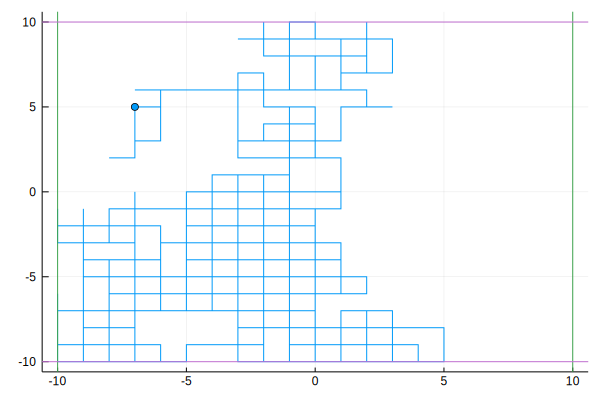

In [19]:
using Plots
N = 1000
L = 20
num_traj = 1

for i in 1:num_traj    
    data = trajectory(Agent(0,0), N, L)
    plot(data, color = i, leg = false)
    scatter!(data[end], color = i)
end
vline!([-L/2,L/2])
hline!([-L/2,L/2])

### Exercise 3: Spatial epidemic model  -- Initialization and visualization

We now have all of the technology in place to simulate an agent-based model in space!

For simplicity we will impose in the model that there is at most one agent on each site at all times, modelling the fact that two people cannot be in the same place as each other.

We thus begin by creating an initial condition for $N$ agents that satisfies this. Later we must make sure that the dynamics also respects this.

1. Write a function `initialize` that takes parameters $L$, the side length of the square box where the agents live, and $N$, the number of agents.

    It should build, one by one, a collection of agents, by proposing a position for each one and checking if that position is occupied. If the position is occupied, it should generate another one, and so on until it finds a free spot.

    You may create additional functions to help with this if you find it useful to do so.

    The agents should all have initial status `S`, except for one of them, e.g. the first in the list, which has initial status `I` -- i.e. it is the only source of infection.

    It should return the `Vector` of `Agent`s.

In [20]:
function initialize(N::Int64, L::Int64)
    all_possible = Set(Tuple{Int64,Int64}[])
    for x in -L/2:L/2
        for y in -L/2:L/2
            push!(all_possible, (x,y))
        end
    end
    agents = Agent[]
    for i in 1:N
        ind = rand(all_possible)
        push!(agents, Agent(ind))
        delete!(all_possible, ind)
    end
    agents[rand(1:length(agents))].state = I
    return agents
end

initialize (generic function with 1 method)

2. Run your initialization function for $L=10$ and $N=20$.

In [21]:
L = 10
N = 20
initialize(N, L);

3. Write a function `visualize_agents` that takes in a collection of agents as argument. It should plot a point for each agent, coloured according to its status.

    You can use the keyword argument `c=cs` inside your call to the plotting function to set the colours of points to a vector of integers called `cs`. Don't forget to use `ratio=1`.

In [22]:
function visualize_agents(v::Vector{Agent})
    color_dict = Dict([(S, :blue), (I, :red), (R, :green)])
    p = plot(leg = false, aspect_ratio =:equal)
    for agent in v
        scatter!(make_tuple(agent.position),  c = color_dict[agent.state])
    end
    return p
end

visualize_agents (generic function with 1 method)

4. Run the function to visualize the initial condition you created.

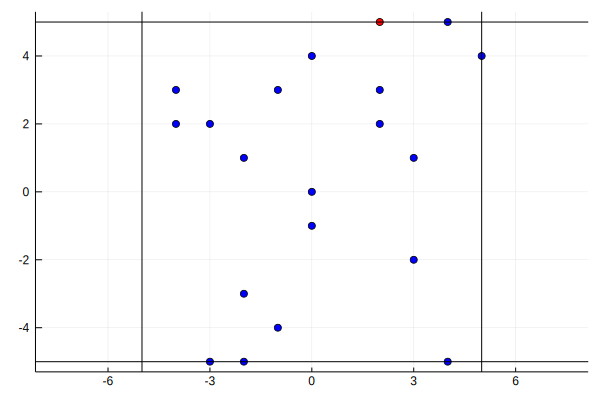

In [23]:
visualize_agents(initialize(N, L))
vline!([-L/2,L/2], c = "black")
hline!([-L/2,L/2], c = "black")

### Exercise 4: Spatial epidemic model -- Dynamics

1. Write a function `step!` that does one step of the dynamics of the model.
It takes as parameters $L$, $p_I$ and $p_R$.
This combines what we did in the last Problem Set with the 2D random walker above.

    The rules are as follows:

    - A single agent is chosen at random; call it agent $i$.

    - A new position is proposed for that agent.

    - If that new position is not occupied, the agent moves there.

    - If the new position *is* occupied, by agent $j$, then *neither* of them move, but they interact
    via the following rule:

    - If agent $i$ is infected and agent $j$ is susceptible then agent $j$ becomes infected with probability $p_I$.

    - If  agent $i$ is infected, it recovers with probability $p_R$.

In [24]:
function step!(vec::Vector{Agent}, L::Int64, pI::Float64, pR::Float64)
    d = Dict(make_tuple(pos(v)) => v for v in vec) #keys are position tups, vals are agents
    cur = vec[rand(1:length(vec))] #andomly select a dude to be in question
    old_loc = make_tuple(pos(cur))
    jump!(cur, L)
    new_loc = make_tuple(pos(cur)) #will return as a tuple
    #try to infect
    if new_loc != old_loc && haskey(d,new_loc)
        interact = d[new_loc]
        set_pos!(cur, Location(old_loc)) #return to old location if he crashed with someone 
        if rand() < pI && interact.state == S && cur.state == I
            interact.state = I
            cur.num_infected += 1
        end
    end
    #try to cure
    if cur.state == I && rand()<pR
        cur.state = R
    end
end    

step! (generic function with 1 method)

2. Make a small system and run the `step!` function a few times to check (by eye) that it's doing the right thing.

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-15123244015834230607\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-14572000124996612177\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-15123244015834230607\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

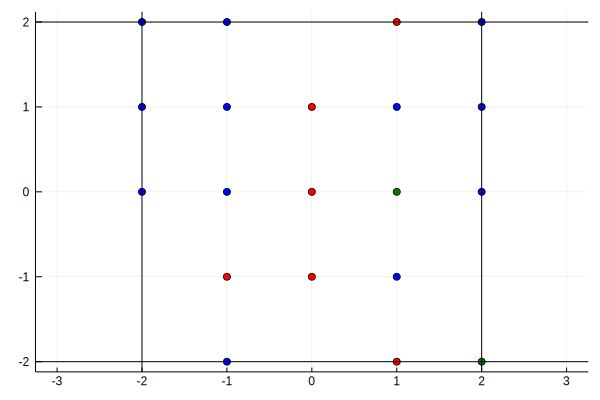

In [25]:
using Interact
N = 20
L = 4
vec = initialize(N, L)
pI = 1.0
pR = 0.05
for i in 1:250
    step!(vec, L, pI, pR)
end
visualize_agents(vec)
vline!([-L/2,L/2], c = "black")
   hline!([-L/2,L/2], c = "black")

3. Make an interactive visualization to display the agents after each step, to again check visually that the implementation is correct.

In [34]:
using Interact
pI = 1.0
pR = 0.05
N = 20
L = 4
vec = initialize(N, L)
hist = Array{Agent,1}[]
for i in 1:250
    step!(vec, L, pI, pR)
    push!(hist,deepcopy(vec))
end
@manipulate for i in 1:length(hist)
    p = visualize_agents(hist[i])
    vline!([-L/2,L/2], c = "black")
    hline!([-L/2,L/2], c = "black")
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["i"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 250,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
125, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "C:\\Users\\2000d\\.julia\\packages\\Knockout\\IP1uR\\src\\..\\assets\\knockout.js"), Asset("js", "knockout_punches", "C:\\Users\\2000d\\.julia\\packages\\Knockout\\IP1uR\\src\\..\\assets\\knockout_punches.js"), Asset("js", nothing, "C:\\Users\\2000d\\.julia\\packages\\InteractBase\\9mFwe\\src\\..\\assets\\all.js"), Asset("css", nothing, "C:\\Users\\2000d\\.julia\\packages\\InteractBase\\9mFwe\\src\\..\\assets\\style.css"), Asset("css", nothing, "C:\\Users\\2000d\\.julia\\packages\\Interact\\SbgIk\\src\\..\\assets\\bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x0000000013acc8b0, Task (runnable) @0x0000000013acc8b0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"28\"

4. Write a function `sweep!` that takes the relevant parameters and performs one sweep, i.e. $N$ steps.

In [27]:
function sweep!(vec::Vector{Agent}, L::Int64, pI::Float64, pR::Float64)
    for i in 1:length(vec)
        step!(vec, L, pI, pR)
    end
end

sweep! (generic function with 1 method)

5. Write a function `dynamics!` that takes the same parameters as `step!`, together with a number of sweeps.

    Run the dynamics for the given number of sweeps.

    Save the state of the whole system, together with the total numbers of $S$, $I$ and $R$ individuals, after each sweep, for later use.

    You may need the function `deepcopy` to copy the state of the whole system.

In [28]:
function dynamics!(vec::Vector{Agent}, L::Int64, pI::Float64, pR::Float64, T::Int64)
    state = Vector{Agent}[deepcopy(vec)]
    Sa = Int64[length(vec)]
    Ia = Int64[0]
    Ra = Int64[0]
    for i in 1:T
        sweep!(vec, L, pI, pR)
        push!(state, deepcopy(vec))
        push!(Sa, count([agent.state == S for agent in vec]))
        push!(Ia, count([agent.state == I for agent in vec]))
        push!(Ra, count([agent.state == R for agent in vec]))
    end
    return state, Sa, Ia, Ra
end

dynamics! (generic function with 1 method)

6. Given one simulation run, write an interactive visualization that shows both the state at time $n$ (using `visualize_agents`) and the history of $S$, $I$ and $R$ from time $0$ up to time $n$. To do this, make two separate plot objects $p_1$ and $p_2$ and use the $hbox$ or $vbox$ function to put them together horizontally or vertically into a single plot.

In [29]:
T = 500
vec = initialize(N,L)
L = 20
N = 100
pI = 0.70
pR = 0.01
states, Sa, Ia, Ra = dynamics!(vec, L, pI, pR, T);

In [30]:
@manipulate for i in 1:T+1
    p1 = visualize_agents(states[i])
    vline!(p1,[-L/2,L/2])
    hline!(p1,[-L/2,L/2])
    p2 = plot(Sa[1:i], xlims = (0,T), label="Susceptible")
    plot!(p2, Ia[1:i],  label="Infected")
    plot!(p2, Ra[1:i],  label="Recovered")
    hbox(p1,p2)
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["i"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 501,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
251, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "C:\\Users\\2000d\\.julia\\packages\\Knockout\\IP1uR\\src\\..\\assets\\knockout.js"), Asset("js", "knockout_punches", "C:\\Users\\2000d\\.julia\\packages\\Knockout\\IP1uR\\src\\..\\assets\\knockout_punches.js"), Asset("js", nothing, "C:\\Users\\2000d\\.julia\\packages\\InteractBase\\9mFwe\\src\\..\\assets\\all.js"), Asset("css", nothing, "C:\\Users\\2000d\\.julia\\packages\\InteractBase\\9mFwe\\src\\..\\assets\\style.css"), Asset("css", nothing, "C:\\Users\\2000d\\.julia\\packages\\Interact\\SbgIk\\src\\..\\assets\\bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x0000000013ac7c70, Task (runnable) @0x0000000013ac7c70), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"28\"

7. Using $L=20$ and $N=100$, experiment with $p_I$ and $p_R$ until you find an epidemic outbreak. (Take $p_R$ quite small.)

In [31]:
T = 500
vec = initialize(N,L)
L = 20
N = 100
pI = 0.60
pR = 0.005
states, Sa, Ia, Ra = dynamics!(vec, L, pI, pR, T)
@manipulate for i in 1:T+1
    p1 = visualize_agents(states[i])
    vline!(p1,[-L/2,L/2])
    hline!(p1,[-L/2,L/2])
    p2 = plot(Sa[1:i], xlims = (0,T), label="Susceptible")
    plot!(p2, Ia[1:i],  label="Infected")
    plot!(p2, Ra[1:i],  label="Recovered")
    hbox(p1,p2)
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["i"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 501,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
251, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "C:\\Users\\2000d\\.julia\\packages\\Knockout\\IP1uR\\src\\..\\assets\\knockout.js"), Asset("js", "knockout_punches", "C:\\Users\\2000d\\.julia\\packages\\Knockout\\IP1uR\\src\\..\\assets\\knockout_punches.js"), Asset("js", nothing, "C:\\Users\\2000d\\.julia\\packages\\InteractBase\\9mFwe\\src\\..\\assets\\all.js"), Asset("css", nothing, "C:\\Users\\2000d\\.julia\\packages\\InteractBase\\9mFwe\\src\\..\\assets\\style.css"), Asset("css", nothing, "C:\\Users\\2000d\\.julia\\packages\\Interact\\SbgIk\\src\\..\\assets\\bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x0000000013591710, Task (runnable) @0x0000000013591710), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"28\"

8. For the values of $p_I$ and $p_R$ that you found in [11],
run 50 simulations. Plot $S$, $I$ and $R$ as a function of time for each of them (with transparency!).

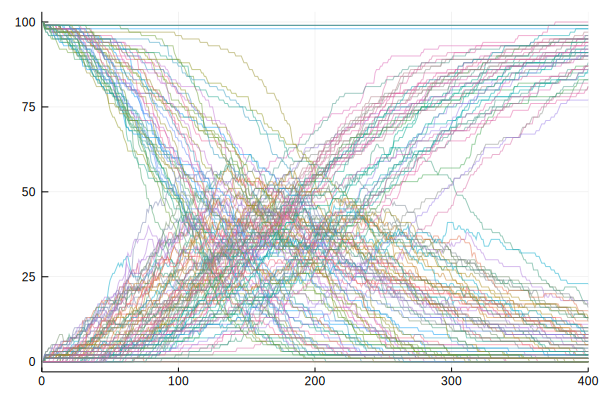

In [32]:
T = 400
L = 20
N = 100
pI = 0.40
pR = 0.01
num_sims = 50
p1 = plot(xlims = (0,T))
for i in 1:num_sims   
    vec = initialize(N,L)
    states, Sa, Ia, Ra = dynamics!(vec, L, pI, pR, T)
    plot!(p1, Sa, alpha=0.5, label="")
    plot!(p1, Ia, alpha=0.5, label="")
    plot!(p1, Ra, alpha=0.5, label="")
end
p1

9. Plot their means with error bars.

    You should see a result that looks like all those plots that you've seen of the
    SIR model on the internet. (If you haven't seen any, then what are you waiting for --
    go and find some!)
    Except that they *never show you error bars*, even though error bars are clearly
    *of the utmost importance*.

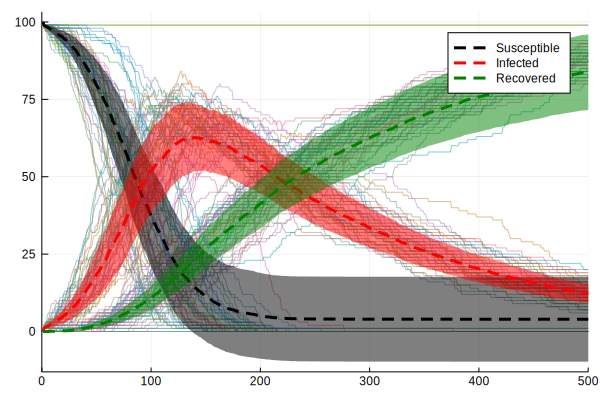

In [33]:
using Statistics
T = 500
L = 20
N = 100
pI = 0.60
pR = 0.005
num_sims = 50
p1 = plot(xlims = (0,T))
Sa_lt = Array{Int64,1}[]
Ia_lt = Array{Int64,1}[]
Ra_lt = Array{Int64,1}[]
for i in 1:num_sims   
    vec = initialize(N,L)
    states, Sa, Ia, Ra = dynamics!(vec, L, pI, pR, T)
    plot!(p1, Sa, alpha=0.5, label="")
    plot!(p1, Ia, alpha=0.5, label="")
    plot!(p1, Ra, alpha=0.5, label="")
    push!(Sa_lt, Sa)
    push!(Ia_lt, Ia)
    push!(Ra_lt, Ra)
end
mean_Sa = [mean([vec[i] for vec in Sa_lt]) for i in 1:T+1]
mean_Ia = [mean([vec[i] for vec in Ia_lt]) for i in 1:T+1]
mean_Ra = [mean([vec[i] for vec in Ra_lt]) for i in 1:T+1]
σSa = Float64[]
σIa = Float64[]
σRa = Float64[]
for timestep in 1:T+1
    ts_mean = mean_Sa[timestep]
    centered_squared_sum = 0.0
    for series in Sa_lt
        centered_squared_sum += (series[timestep]-ts_mean)^2
    end
    ts_sigma = sqrt(centered_squared_sum/N)
    push!(σSa, ts_sigma)
end
for timestep in 1:T+1
    ts_mean = mean_Ia[timestep]
    centered_squared_sum = 0.0
    for series in Ia_lt
        centered_squared_sum += (series[timestep]-ts_mean)^2
    end
    ts_sigma = sqrt(centered_squared_sum/N)
    push!(σIa, ts_sigma)
end
for timestep in 1:T+1
    ts_mean = mean_Ra[timestep]
    centered_squared_sum = 0.0
    for series in Ra_lt
        centered_squared_sum += (series[timestep]-ts_mean)^2
    end
    ts_sigma = sqrt(centered_squared_sum/N)
    push!(σRa, ts_sigma)
end
plot!(p1,mean_Sa,ribbon = σSa,fillalpha=.5,lw=3,linestyle=:dash,color=:black, label = "Susceptible")
plot!(p1,mean_Ia,ribbon = σIa,fillalpha=.5,lw=3,linestyle=:dash,color=:red, label = "Infected")
plot!(p1,mean_Ra,ribbon = σRa,fillalpha=.5,lw=3,linestyle=:dash,color=:green, label = "Recovered")
p1

### Exercise 5 (Extra credit -- or for summer vacation): Social distancing

We can use a variant of the above model to investigate the effect of the
totally mis-named "social distancing"  
(we want people to be socially *close*, but *physically* distant).

In this variant, we separate out the two effects "infection" and
"movement": an infected agent chooses a
neighbouring site, and if it finds a susceptible there then it infects it
with probability $p_I$.

Separately, an agent chooses a neighbouring site to move to,
moves there with probability $p_M$ if the site is vacant. (Otherwise it
stays where it is.)

1. When $p_M = 0$, the agents cannot move, and hence are
completely quarantined in their original locations.
Where can the disease spread in this case?

    Run the dynamics repeatedly, looking at which sites become infected.
    (Draw them!)

    How does this change as you increase the *density*
    $\rho = N / (L^2)$ of agents?  Start with a small density.

    This is basically the [**site percolation**](https://en.wikipedia.org/wiki/Percolation_theory)
    model.

2. When we start to increase $p_M$, we allow some local motion via random walk.
Investigate how this leaky quarantine affects the infection dynamics with
different densities.

# From Pset5:
### Exercise 5: Putting it all together -- fitting an SIR model to data

In this exercise we will fit the (non-spatial) SIR ODE model from Exercise 1 to the (spatial) data you generated in Problem Set 4. If we are able to find a good fit, that might (or might not) constitute evidence that space "does not matter" too much for the dynamics of these models. If the fit is not so good, perhaps there is an important effect of space. (As usual in statistics, and indeed in modelling in general, we should cautious of making categorical claims.)

This fitting procedure will be different from that in Exercise 4, however: we no longer have an explicit form for the function that we are fitting! So what should we do?

We will try to find the parameters $\beta$ and $\gamma$ for which *the output of the ODEs when we simulate it with those parameters* best matches the data!

1. Re-run your spatial simulation from Problem Set 4 for a bigger system and make sure there is an epidemic outbreak for the parameters you use.

    Save the data to a CSV file from that notebook, using the following code. You may need to install the `Tables` package.

    ```julia
    using CSV, Tables

    CSV.write("mydata.csv", Tables.table(M))
    ```

    where `M` is a matrix storing $t$, $S$, $I$ and $R$ as a function of time $t$ in separate columns.

    If you have vectors, you can make them into a matrix using `hcat(ts, Ss, Is, Rs)`. If you prefer, you can make a dataframe instead.

In [ ]:
T = 500
vec = initialize(N,L)
L = 150
N = 10000
pI = 0.60
pR = 0.08
states, Sa, Ia, Ra = dynamics!(vec, L, pI, pR, T)
p1 = visualize_agents(states[end])
vline!(p1,[-L/2,L/2])
hline!(p1,[-L/2,L/2])
p2 = plot(Sa, xlims = (0,T), label="Susceptible")
plot!(p2, Ia,  label="Infected")
plot!(p2, Ra,  label="Recovered")
hbox(p1,p2)

In [ ]:
using CSV, Tables
ts = collect(1:length(Sa))
M = hcat(ts, Sa, Ia, Ra)
CSV.write("mydata.csv", Tables.table(M))